* Edmunds, Amazon, Tripadvisor uci 리뷰 데이터
    * 51개의 .data 확장자 파일 
* (1) 주제별로 군집화
* (2) 문서 유사도

**TF-IDF (Term Frequency-Inverse Document Frequency) 벡터화**
* 문서의 유사도를 구하는 작업, 검색 시스템에서 검색 결과의 중요도를 정하는 작업, 문서 내에서 특정 단어의 중요도를 구하는 작업 등에 쓰임
* 카운트 벡터화의 보완
    * 단어 피처에 단어 count를 부여하는 방법
    * 문장에서 자주 사용될 수밖에 없는 단어들에도 높은 가중치가 부여되는 단점
* TF * IDF
    * 자주 나타나는 단어에 높은 가중치를 줌 & 모든 문서에서 높은 빈도로 나타나는 단어에 패널티 부여
        * ex) 당연히-와 같은 불용어
    * TF-IDF 값이 크면 중요도가 높고, 낮으면 중요도가 적은 단어
    * TF (Term Frequency) : 개별 문서에서의 단어 i 빈도
    * DF (Document Frequency) : 단어 i가 등장한 문서의 개수
    * IDF (Inverse Document Frequency) : DF의 역수 

![tf-idf](tf-idf.png)

In [1]:
# Module
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from glob import glob
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings; warnings.filterwarnings('ignore')

file_dir = './opinion_data/topics/'
file_titles, contents = [], []

# 파일 제목과 파일 내용을 담고 있는 DataFrame 생성 (df)
# print(glob(os.path.join(file_dir, '*.data'))[0]) # file 포맷 예시 출력
for file in glob(os.path.join(file_dir, '*.data')):
    # 파일 제목
    file_title = file.split('/')[-1].split('.')[0]
    file_titles.append(file_title)
    # 파일 내용
    contents.append(pd.read_table(file, header=0, encoding='latin1'))
    
df = pd.DataFrame({'title':file_titles
                   , 'content':contents})
print(df.shape)
display(df.head())

(51, 2)


,title,content
0,battery-life_ipod_nano_8gb,short battery life I moved up from a...
1,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fa...
2,room_holiday_inn_london,"We arrived at 23,30 hours and they could n..."
3,location_holiday_inn_london,Great location for tube and we crammed in...
4,staff_bestwestern_hotel_sfo,Staff are friendly and hel...


In [5]:
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import WordPunctTokenizer
import string
# from nltk.stem import WordNetLemmatizer

In [2]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

2022-09-21 14:47:14.329958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
text_to_word_sequence('ABCD3.33!!2ss^^!ait')

['abcd3', '33', '2ss', 'ait']

In [32]:
# 소문자 (lower_content)
def content_lower(row):
    li = []
    for i in row:
        for j in i:
            li.append(j.lower())
    return li

df['lower_content'] = content_lower(df['content'])

# 특수문자 제거 (del_punc)
del_punc = dict((ord(punc), None) for punc in string.punctuation)  # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 를 아스키 코드로 변환 후 None


# 표제어 추출을 위한 Lemmatization 커스텀 코드 작업
# Lemmatization : am, are, is의 뿌리 단어 = be

import nltk
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('punkt')
# dler = nltk.downloader.Downloader()
# dler._update_index()
# dler.download('all')


import string
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def token(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def LemNormalizer(text):
    return token(text_to_word_sequence(text))

# TF-IDF 벡터화
tfidf = TfidfVectorizer(tokenizer=LemNormalizer,
                       stop_words='english',
                       ngram_range=(1, 2), 
                       min_df=0.05, max_df=0.90) # min_df : 전체 documents에서 너무 낮은 빈도의 단어 피처는 제외 (하위 5% 이하의 빈도수를 지닌 단어는 제외)
                                                 # max_df : 전체 documents에서 너무 높은 빈도의 단어 피처는 제외 (0%~90% 의 빈도수를 지닌 단어만 포함, 상위 10% 빈도수의 단어는 제외)
                                                 # ngram_range : 단어 묶음 1~2개로 설정 (단어가 여러 개 묶여야 의미를 갖는 단어들이 있으므로)
# fit_transform content (피처 벡터화된 matrix)
vect = tfidf.fit_transform(df['lower_content'])
vect

<51x27 sparse matrix of type '<class 'numpy.float64'>'
	with 106 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.cluster import KMeans

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

df['cluster'] = cluster_label
df.sort_values(by='cluster')
print(df.cluster.value_counts())

0    32
2    12
1     7
Name: cluster, dtype: int64


In [11]:
df.loc[df['cluster']==2]

,title,content,lower_content,cluster
2,room_holiday_inn_london,"We arrived at 23,30 hours and they could n...","we arrived at 23,30 hours and they could not r...",2
3,location_holiday_inn_london,Great location for tube and we crammed in...,great location for tube and we crammed in a f...,2
12,keyboard_netbook_1005ha,", I think the new keyboard rivals the gre...",", i think the new keyboard rivals the great h...",2
14,video_ipod_nano_8gb,"I bought the 8, gig Ipod Nano that has the...","i bought the 8, gig ipod nano that has the bui...",2
20,staff_swissotel_chicago,The staff at Swissotel were not particula...,the staff at swissotel were not particularly ...,2
22,interior_toyota_camry_2007,"First of all, the interior has way too ma...","first of all, the interior has way too many c...",2
23,transmission_toyota_camry_2007,"After slowing down, transmission has to b...","after slowing down, transmission has to be k...",2
28,price_holiday_inn_london,"All in all, a normal chain hotel on a nice...","all in all, a normal chain hotel on a nice loc...",2
38,navigation_amazon_kindle,"In fact, the entire navigation structure h...","in fact, the entire navigation structure has ...",2
46,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , Helpless...","great location , nice rooms , helpless con...",2


In [39]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2
label2_indexes = df[df['cluster']==2].index
print('2로 클러스터링 된 문서들의 DF Index:', label2_indexes)

# 첫번째 문서를 추출하여 파일명 표시
comparison_doc = df.iloc[label2_indexes[0]]['title']
print('\n비교 기준 문서명 ', comparison_doc+'과 타 문서 유사도')

'''df에서 추출한 Index 객체를 vect로 입력하여 클러스터링된 vect 추출 
이를 이용하여 cluster=2로 클러스터링된 문서 중 첫 번째 문서와 다른 문서간의 코사인 유사도 측정'''
similarity_cluster2 = cosine_similarity(vect[label2_indexes[0]] , vect[label2_indexes])
print(similarity_cluster2)

2로 클러스터링 된 문서들의 DF Index: Int64Index([2, 3, 12, 14, 20, 22, 23, 28, 38, 46, 47, 49], dtype='int64')

비교 기준 문서명  room_holiday_inn_london과 타 문서 유사도
[[1.         0.         0.         0.         0.72291615 0.
  0.         0.32167346 0.         0.51391196 0.3436457  0.43799056]]


Text(0.5, 1.0, 'room_holiday_inn_london')

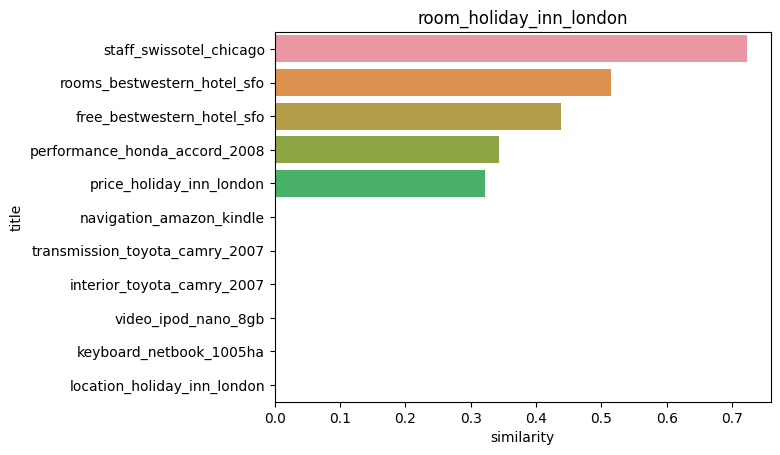

In [42]:
# argsort()를 이용, 첫 번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환 (자기 자신 제외) 
sorted_index = similarity_cluster2.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 index를 추출하여 다시 정렬 
re_sorted_indexes = label2_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
cluster2_sim_value = np.sort(similarity_cluster2.reshape(-1))[::-1]
cluster2_sim_value = cluster2_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
cluster2_sim_df = pd.DataFrame()
cluster2_sim_df['title'] = df.iloc[re_sorted_indexes]['title']
cluster2_sim_df['similarity'] = cluster2_sim_value

sns.barplot(x='similarity', y='title',data=cluster2_sim_df)
plt.title(comparison_doc)